In [1]:
import torch
import pandas as pd
import json
import transformer_ee.dataloader.string_conv as string_conv
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset


In [2]:
mps_device = torch.device("mps")

In [3]:
df = pd.read_csv(
    "transformer_ee/data/2022-08-21_rnne_NC_250_fGScatter_20MeV_KE_01e8_max_trackE_cut.csv.xz"
)

with open("transformer_ee/config/input.json", "r") as f:
    input_d = json.load(f)


In [4]:
for particle_feature in input_d["vector"]:
    df[particle_feature] = df[particle_feature].apply(string_conv.string_to_float_list)


In [5]:
class Pandas_NC_Dataset(Dataset):
    def __init__(self, dataframe, config: dict):
        self.df = dataframe
        self.len = len(dataframe)
        self.maxpronglen = config["max_num_prongs"]
        self.vectornames = config["vector"]
        self.scalarnames = config["scalar"]
        self.targetname = config["target"]

        # calculate mean and std for normalization
        self.stat_scalar = []
        for x in self.scalarnames:
            self.stat_scalar.append([df[x].mean(), df[x].std()])
        self.stat_scalar = torch.Tensor(self.stat_scalar).T
        self.stat_scalar = self.stat_scalar[:, None, :]

        self.stat_vector = []
        for x in self.vectornames:
            _tmp = []
            for y in df[x]:
                _tmp.extend(y)
            self.stat_vector.append([np.mean(_tmp), np.std(_tmp)])
        self.stat_vector = torch.Tensor(self.stat_vector).T
        self.stat_vector = self.stat_vector[:, None, :]
        self.d={}

    def __getitem__(self, index):
        if index in self.d:
            return self.d[index]

        row = self.df.iloc[index]
        _vectorsize = len(row[self.vectornames[0]])
        _vector = torch.Tensor(row[self.vectornames]).T
        _scalar = torch.Tensor(row[self.scalarnames]).T
        _vector = (_vector - self.stat_vector[0]) / self.stat_vector[1]
        _scalar = (_scalar - self.stat_scalar[0]) / self.stat_scalar[1]

        return_tuple = (
            # pad the vector to maxpronglen with zeros
            F.pad(_vector, (0, 0, 0, self.maxpronglen - _vectorsize), "constant", 0),
            # return the scalar
            _scalar,
            # return src_key_padding_mask
            F.pad(
                torch.zeros(_vectorsize, dtype=torch.bool),
                (0, self.maxpronglen - _vectorsize),
                "constant",
                1, # pad with True
            ),
            torch.Tensor(row[self.targetname]),
        )
        self.d[index] = return_tuple
        return return_tuple

    def __len__(self):
        return self.len


In [6]:
dataset = Pandas_NC_Dataset(df, input_d)

batch_size_train = 256
batch_size_test = 1024


In [7]:
seed = 0
_indices = np.arange(len(df))
np.random.seed(seed)
np.random.shuffle(_indices)
test_size = 0.2
train_indicies = _indices[: int(len(_indices) * (1 - test_size))]
test_indicies = _indices[int(len(_indices) * (1 - test_size)) :]

In [8]:
from torch.utils.data import Subset

train_dataset = Subset(dataset, train_indicies)
test_dataset = Subset(dataset, test_indicies)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train,
                                            shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test,
                                            shuffle=False)

In [9]:
from transformer_ee.model.transformerEncoder import Transformer_EE_v1
net=Transformer_EE_v1().to(mps_device)

In [10]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [11]:
loss_list = []
epochs = 100
error_list = []
lossfunc = nn.MSELoss()

for i in range(epochs):

    net.train()  # begin training

    for (batch_idx, batch) in enumerate(trainloader):
        vector_train_batch = batch[0].to(mps_device)
        scalar_train_batch = batch[1].to(mps_device)
        mask_train_batch = batch[2].to(mps_device)
        target_train_batch = batch[3].to(mps_device)

        Netout = net.forward(vector_train_batch, mask_train_batch)
        # This will call the forward function, usually it returns tensors.

        loss = lossfunc(Netout, target_train_batch)  # regression loss

        # Zero the gradients before running the backward pass.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to all the learnable
        # parameters of the model. Internally, the parameters of each Module are stored
        # in Tensors with requires_grad=True, so this call will compute gradients for
        # all learnable parameters in the model.
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

        loss_list.append(loss)
        if batch_idx % 1 == 0:
            # print("Epoch: {}, batch: {} Loss: {} label_loss:{}".format(i, batch_idx, loss, label_loss_))
            print("Epoch: {}, batch: {} Loss: {:0.4f}".format(i, batch_idx, loss))


/var/folders/f_/6c826v810dx25pkgjg_810h00000gn/T/ipykernel_50310/2925751015.py:34: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3281.)
  _scalar = torch.Tensor(row[self.scalarnames]).T


Epoch: 0, batch: 0 Loss: 9.9136
Epoch: 0, batch: 1 Loss: 10.8517
Epoch: 0, batch: 2 Loss: 3.6168
Epoch: 0, batch: 3 Loss: 3.7671
Epoch: 0, batch: 4 Loss: 3.2210
Epoch: 0, batch: 5 Loss: 1.8976
Epoch: 0, batch: 6 Loss: 1.9774
Epoch: 0, batch: 7 Loss: 2.1508
Epoch: 0, batch: 8 Loss: 2.2055
Epoch: 0, batch: 9 Loss: 2.2286
Epoch: 0, batch: 10 Loss: 2.0741
Epoch: 0, batch: 11 Loss: 1.9085


KeyboardInterrupt: 

In [33]:
torch.save(net.state_dict(), "transformer_ee/model/transformer_ee_v1.pt")


In [ ]:
from transformer_ee.model.transformerEncoder import Transformer_EE_v1

net=Transformer_EE_v1()
net.load_state_dict(torch.load("transformer_ee/model/transformer_ee_v1.pt"))
net.eval()

In [12]:
net.eval()
net.to(mps_device)
a, b, c, d=next(iter(testloader))
net.cpu()
e=net.forward(a, c)


mean resolution:  -0.33735633
std resolution:  0.35867745


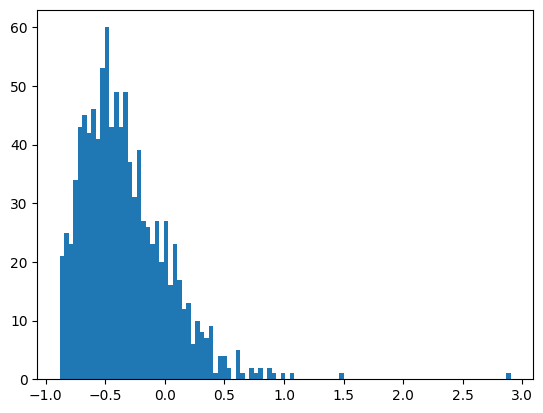

Transformer_EE_v1(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
        )
        (linear1): Linear(in_features=12, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=12, bias=True)
        (norm1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
        )
        (linear1): Linear(in_features=12, out_features=2048, bias=True)
        (dropout): Dropout(

In [13]:
from matplotlib import pyplot as plt
trueval=d[:, 0].cpu().detach().numpy()
prediction=e[:, 0].cpu().detach().numpy()
resolution=(prediction-trueval)/trueval
print("mean resolution: ", np.mean(resolution))
print("std resolution: ", np.std(resolution))
plt.hist(resolution, bins=100)
plt.show()
net.to(mps_device)

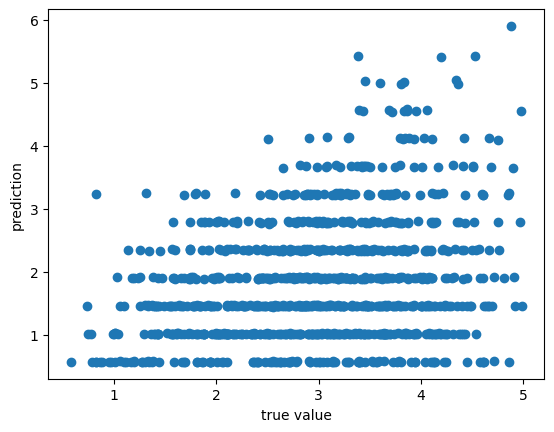

In [14]:
plt.scatter(trueval, prediction)

plt.xlabel("true value")
plt.ylabel("prediction")
plt.show()

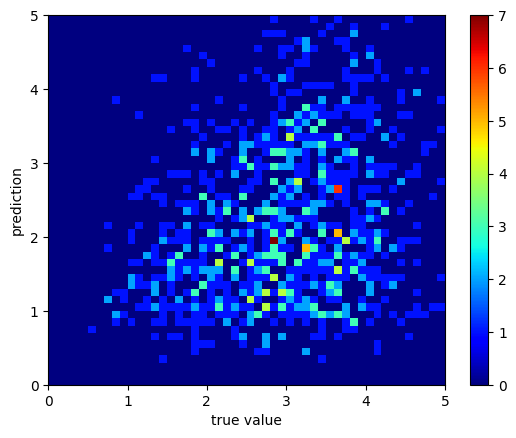

In [20]:
plt.hist2d(trueval, prediction, bins=(50, 50), cmap=plt.cm.jet, range=[[0, 5], [0, 5]])
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel("true value")
plt.ylabel("prediction")
plt.colorbar()
plt.show()

In [16]:
print(net.linear.weight)

Parameter containing:
tensor([[ 0.0826,  0.2156, -0.2129,  0.2783, -0.1241,  0.0631, -0.0142, -0.2118,
          0.1924, -0.1685,  0.0136,  0.0490],
        [-0.1377,  0.0334, -0.0112, -0.2163, -0.0388,  0.0768,  0.1274,  0.1059,
         -0.0129,  0.1251,  0.1158,  0.1096]], device='mps:0',
       requires_grad=True)


/opt/homebrew/lib/python3.10/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


In [17]:
print(net.linear.bias)

Parameter containing:
tensor([-0.1471,  0.3031], device='mps:0', requires_grad=True)


In [29]:
prediction

array([0.59756434, 2.1441917 , 3.961756  , ..., 1.209625  , 6.2449536 ,
       0.6619846 ], dtype=float32)

In [26]:
a

tensor([[[ 1.3970e+00,  2.1801e+00,  1.6237e+00,  ...,  4.4725e-01,
           4.4726e-01,  4.0303e-01],
         [-7.1584e-01, -3.1329e-01,  1.6254e+00,  ..., -9.2862e-02,
          -9.2861e-02, -2.4834e-01],
         [-7.1584e-01, -6.6090e-01,  1.6229e+00,  ..., -5.0540e-01,
          -5.0540e-01, -5.2792e-01],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[-7.1584e-01, -9.8494e-02, -7.5849e-01,  ..., -2.2304e-01,
          -2.2303e-01, -2.2293e-02],
         [-7.1584e-01, -5.2142e-01, -8.5963e-01,  ..., -4.0816e-01,
          -4.0816e-01, -4.4761e-01],
         [-7.1584e-01, -5.8599e-01, -7.8101e-01,  ..., -3.9952e-01,
          -3.9952e-01, -5.5171e-01],
         ...,
         [ 0.0000e+00,  0

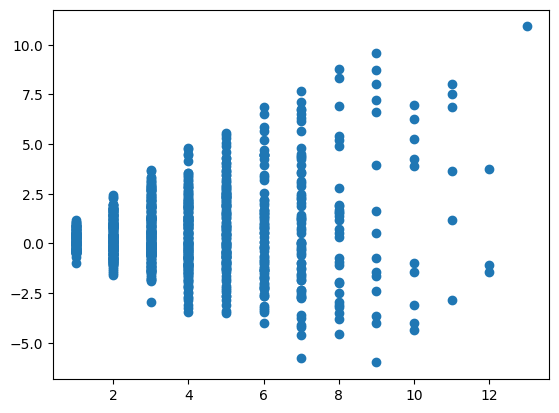

In [14]:
plt.scatter(np.sum(np.array(a[:, :, 0], dtype=bool), axis=1), prediction)

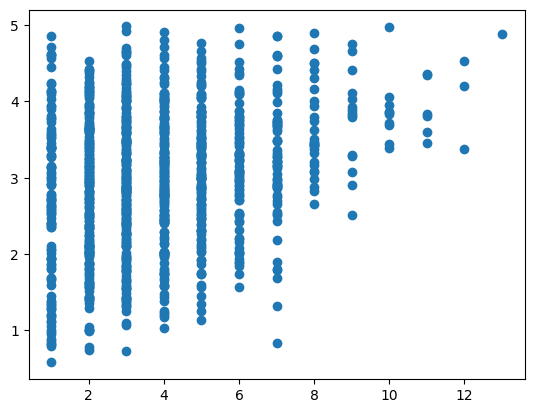

In [15]:
plt.scatter(np.sum(np.array(a[:, :, 0], dtype=bool), axis=1), trueval)

In [34]:
a[:, :, 0].shape

torch.Size([1024, 20])

In [27]:
np.sum(np.array(a[:, :, 0], dtype=bool), axis=1)

array([ 3,  3, 12, ...,  3, 11,  4])

<AxesSubplot: >

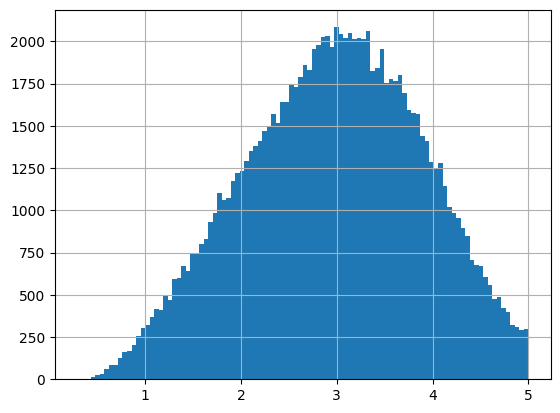

In [25]:
df['mc.nuE'].hist(bins=100)